In [4]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf

OmegaConf.register_new_resolver(
    "relpath", lambda p: str(Path('/disk/scratch2/nkudryas/BAND-torch/notebooks/').parent / p)
)

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "6"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ValueError: resolver 'relpath' is already registered

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import h5py
from sklearn.linear_model import Ridge 
from sklearn.decomposition import PCA
from tqdm import tqdm

from lfads_torch.metrics import r2_score


Matplotlib created a temporary cache directory at /tmp/matplotlib-kur5i216 because the default path (/afs/inf.ed.ac.uk/user/n/nkudryas/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
dataset_name = 'chewie_10_07_mov'
# model_str='kl1_gauss_bd'
# model_str='kl1_gauss_bd_d20_causal_ci'
model_str='kl1_gauss_bd_d20_causal_ci_lowl1'
# model_str='kl1_gauss_causal_nosplit'

bin_size_ms = 10

N_FOLDS = 5

In [43]:
models_dest = f"/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/{dataset_name}"

fac_dim, co_dim = 8,4
bw = 0.1
encod_seq_len = 99 #101
encod_data_dim = 207
seed = 2
model_names = [f'{model_name}_both_{fac_dim}f_{co_dim}c_{model_str}' for model_name in ['lfads','band']]
model_dests = [[f"{models_dest}_cv{cv}/{model_name}" for cv in range(N_FOLDS)] for model_name in model_names]

model_dests


[['/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv0/lfads_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv1/lfads_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv2/lfads_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv3/lfads_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv4/lfads_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1'],
 ['/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv0/band_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv1/band_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_

In [44]:
# model_dests[0][-1] = '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_05_cv4/lfads_both_8f_4c_kl1_gauss_bd'
# model_dests[0] = [f"/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/{dataset_name}_cv{cv}/lfads_both_8f_4c_kl1_gauss_bd_causal_ci" for cv in range(N_FOLDS)]
model_dests

[['/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv0/lfads_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv1/lfads_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv2/lfads_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv3/lfads_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv4/lfads_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1'],
 ['/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv0/band_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv1/band_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1',
  '/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_

In [45]:
import torch
from hydra.utils import instantiate
from pathlib import Path
import hydra

from lfads_torch.band_utils import flatten

models = []
for fold in range(N_FOLDS):

    overrides={
            "datamodule": dataset_name.split('_cv')[0],
            "datamodule.fold": fold,
            "model": model_str, # older models were run with list of beh decoders
            "model.encod_seq_len": encod_seq_len,
            "model.recon_seq_len": encod_seq_len,
            "model.kl_co_scale": float(encod_seq_len),
            "model.fac_dim": fac_dim,
            "model.co_dim": co_dim,
            "model.encod_data_dim": encod_data_dim,
            # "model.behavior_weight": bw,
        }
    # config_path="../../configs/pbt.yaml"
    config_path="../../configs/single.yaml"
    print(config_path)

    # Compose the train config with properly formatted overrides
    config_path = Path(config_path)
    overrides = [f"{k}={v}" for k, v in flatten(overrides).items()]
    with hydra.initialize(
        config_path=config_path.parent,
        job_name="get_weights",
        version_base="1.1",
    ):
        config = hydra.compose(config_name=config_path.name, overrides=overrides)

    # Instantiate `LightningDataModule` and `LightningModule`
    datamodule = instantiate(config.datamodule, _convert_="all")
    model = instantiate(config.model)

    from glob import glob
    checkpoint_folders = glob(model_dests[-1][fold]+'/best_model/checkpoint*')

    print(model_dests[-1][fold])

    # ckpt_path = checkpoint_folders[-1] + '/tune.ckpt'
    ckpt_path = f'{model_dests[-1][fold]}/lightning_checkpoints/last.ckpt'
    model.load_state_dict(torch.load(ckpt_path)["state_dict"])

    models.append(model)

../../configs/single.yaml
/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv0/band_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1
../../configs/single.yaml
/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv1/band_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1
../../configs/single.yaml
/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv2/band_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1
../../configs/single.yaml
/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv3/band_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1
../../configs/single.yaml
/disk/scratch2/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv4/band_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1


FOLD 0


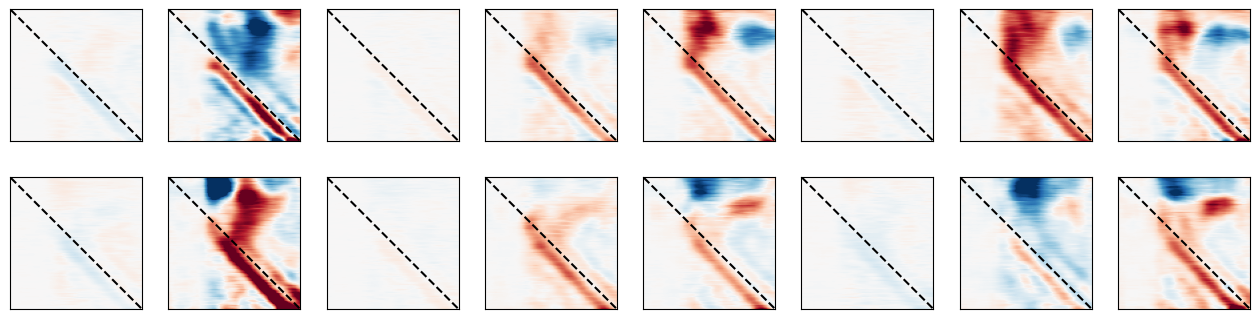

FOLD 1


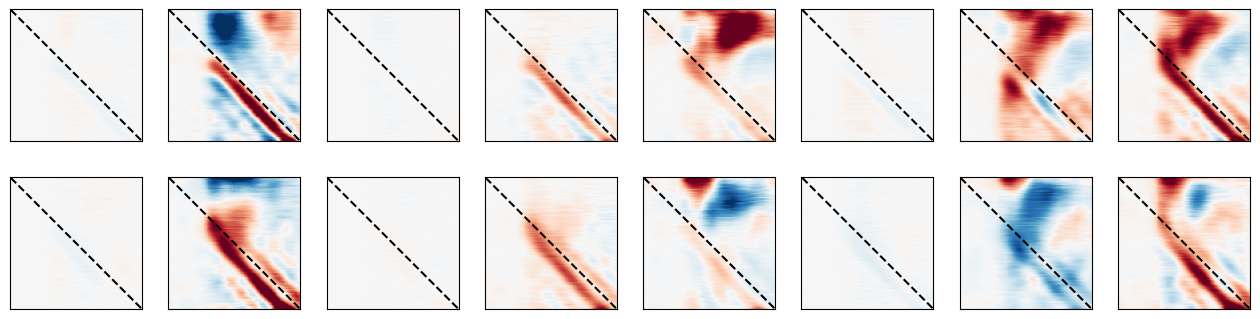

FOLD 2


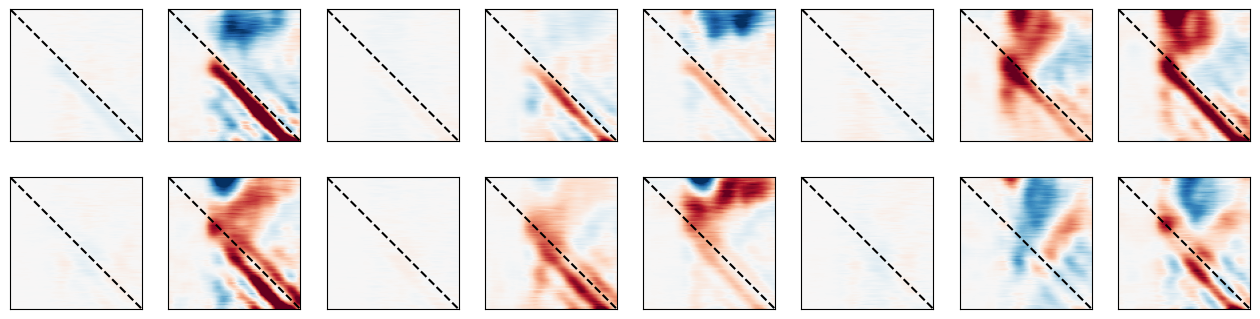

FOLD 3


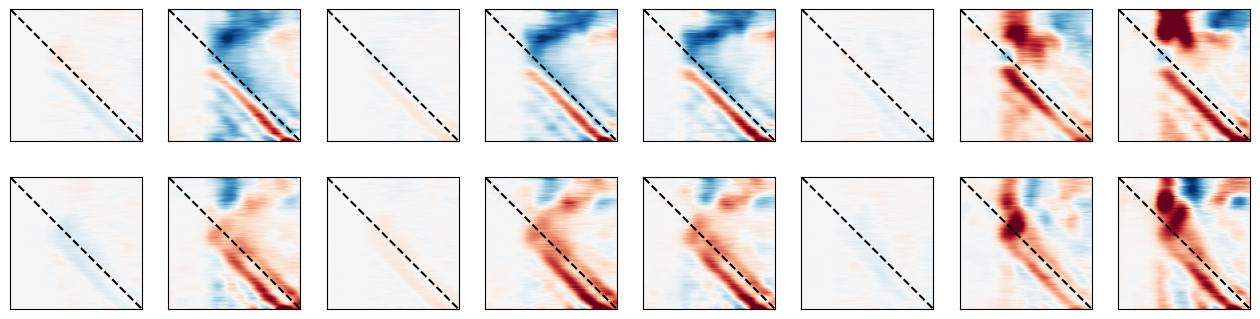

FOLD 4


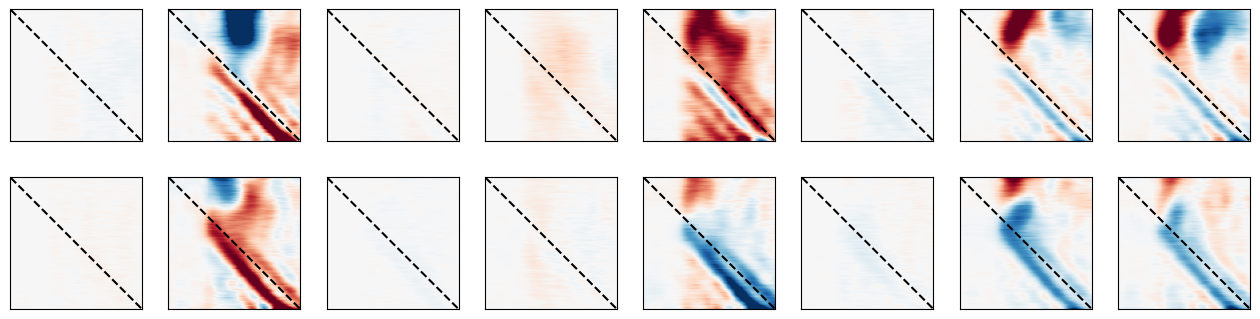

In [46]:
beh_Ws = []
for fold, model in enumerate(models):
    seq_len = config.model.recon_seq_len
    # in_features = config.model.behavior_readout.modules[0].in_features
    # out_features = config.model.behavior_readout.modules[0].out_features
    # beh_W = model.behavior_readout[0].layers[1].weight.T

    in_features = config.model.behavior_readout.in_features
    out_features = config.model.behavior_readout.out_features
    beh_W = model.behavior_readout.layers[2].weight.T

    assert beh_W.shape == (in_features*seq_len, out_features*seq_len)

    beh_W = beh_W.reshape((seq_len, in_features, seq_len, out_features))

    r = torch.std(beh_W)*4
    print('FOLD', fold)
    fig, ax = plt.subplots(out_features, min(in_features,10), figsize=(2*min(in_features,10), 2*out_features))
    for j in range(min(in_features,10)):
        for i in range(out_features):
            ax[i,j].imshow(beh_W[:,j,:,i].detach().numpy(), cmap='RdBu', vmin=-r, vmax=r)
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            ax[i,j].plot([0,seq_len-1], [0, seq_len-1], 'k--')

    plt.show()

    beh_Ws.append(beh_W)

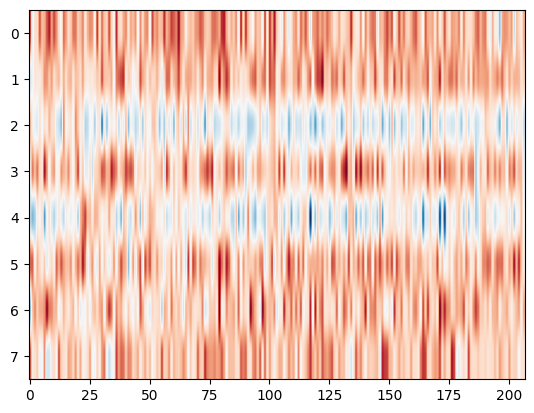

In [47]:
n_W = model.readout[0].weight.T
plt.imshow(n_W.detach().numpy(),interpolation=None, cmap='RdBu',aspect='auto')

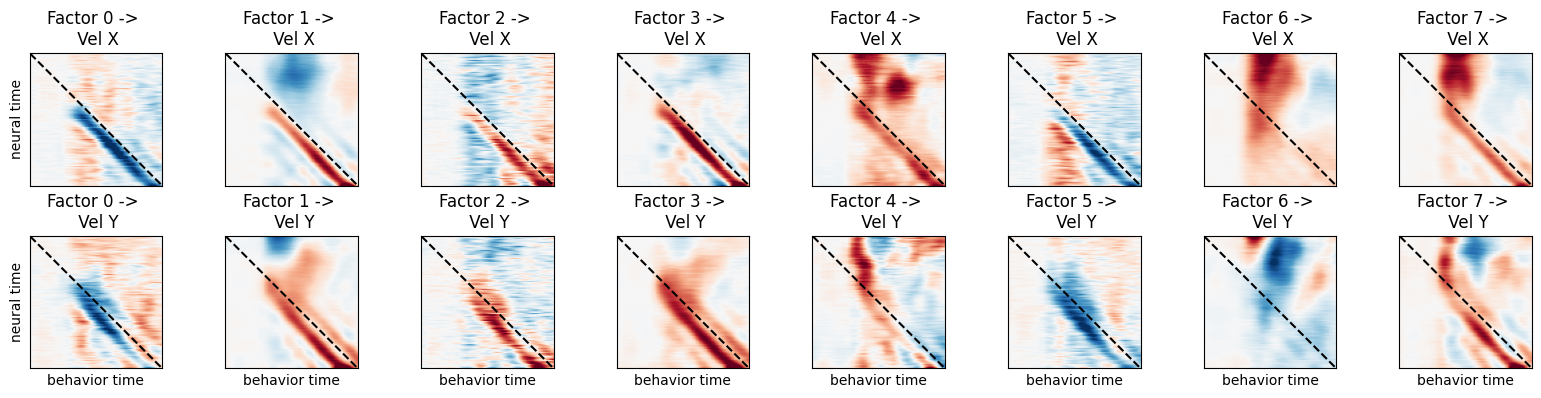

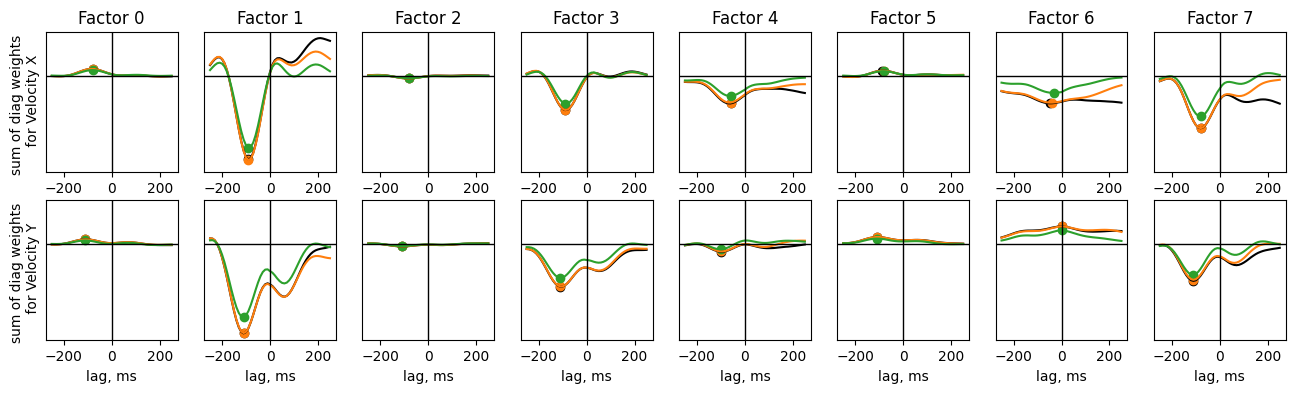

In [48]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

cutoff,co_color = 25, 'C1'
cutoff2,co_color2 = 45, 'C2'

beh_W = np.array([b.detach().numpy() for b in beh_Ws]).mean(0)
fig, ax = plt.subplots(out_features,min(in_features,10), figsize=(2*min(in_features,10), 2*out_features))
for j in range(min(in_features,10)):
    for i in range(out_features):
        r = np.std(beh_W[:,j,:,i])*4
        im = ax[i,j].imshow(beh_W[:,j,:,i], cmap='RdBu', vmin=-r, vmax=r)
        # ax[i,j].axvline(cutoff, color=co_color, linewidth=1)
        # ax[i,j].axhline(cutoff, color=co_color, linewidth=1)
        # ax[i,j].axvline(cutoff2, color=co_color2, linewidth=1)
        # ax[i,j].axhline(cutoff2, color=co_color2, linewidth=1)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].plot([0,seq_len-1], [0, seq_len-1], 'k--')
        # # add a colorbar
        # cbar = plt.colorbar(im, ax=ax[i,j])
        # cbar.set_label('weight')
    ax[0,j].set_title(f'Factor {j} -> \n Vel X')
    ax[1,j].set_title(f'Factor {j} -> \n Vel Y')

for i in range(out_features):
    ax[i,0].set_ylabel(f'neural time')
for j in range(min(in_features,10)):
    ax[-1,j].set_xlabel(f'behavior time')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(out_features, min(in_features,10), figsize=(2*min(in_features,10), 2*out_features),sharey=True)
for j in range(min(in_features,10)):
    for i in range(out_features):
        for co, co_c in zip([0,cutoff,cutoff2],['k',co_color,co_color2]):
            w = beh_W[:,j,:,i][co:,co:]
            # ax[i,j].imshow(w)
            lags = np.arange(-25, 26)
            amp = np.zeros_like(lags, dtype=float)
            for k,lag in enumerate(lags):
                amp[k] = np.sum(np.diag(w, k=lag))
            ax[i,j].plot(10*lags,amp, color=co_c)
            id_max = np.argmax(np.abs(amp))
            ax[i,j].scatter(10*lags[id_max], amp[id_max], color=co_c)
        ax[i,j].axhline(0, color='k', linewidth=1)
        ax[i,j].axvline(0, color='k', linewidth=1)
        # ax[i,j].axhline(w.mean(), color='r', linewidth=1)
        ax[i,j].set_yticks([])
        
    ax[0,j].set_title(f'Factor {j}')
    ax[-1,j].set_xlabel(f'lag, ms')

for i,n in enumerate(['Velocity X','Velocity Y']):
    ax[i,0].set_ylabel(f'sum of diag weights \n for {n}')
    

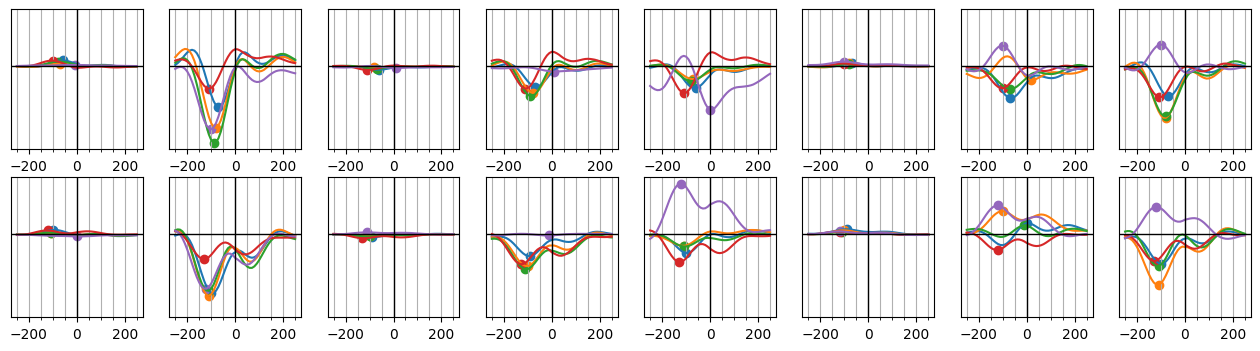

In [49]:
fig, ax = plt.subplots(out_features, min(in_features,10), figsize=(2*min(in_features,10), 2*out_features),sharey=True)
for j in range(min(in_features,10)):
    for i in range(out_features):
        for fold in range(N_FOLDS):
            w = beh_Ws[fold][:,j,:,i].detach().numpy()[50:,50:]
            lags = np.arange(-25, 26)
            amp = np.zeros_like(lags, dtype=float)
            for k,lag in enumerate(lags):
                amp[k] = np.sum(np.diag(w, k=lag))
            ax[i,j].plot(10*lags,amp)
            id_max = np.argmax(np.abs(amp))
            ax[i,j].scatter(10*lags[id_max], amp[id_max])
            
        ax[i,j].axhline(0, color='k', linewidth=1)
        ax[i,j].axvline(0, color='k', linewidth=1)
        ax[i,j].set_yticks([])
        ax[i,j].xaxis.set_minor_locator(MultipleLocator(50))
        ax[i,j].grid(True,which='both')

In [50]:
trial_num = 0
for fold in range(N_FOLDS):
    datafile_pattern = config.datamodule.datafile_pattern.replace(".h5", f"_cv{fold}.h5")
    data_paths = sorted(glob(datafile_pattern))
    assert len(data_paths) == 1, 'Assumed a single dataset, got more'
    dataset_filename = data_paths[0] 
    sess_name='sess0' if fac_dim == 100 else ('go' if fold is None else f'cv{fold}') 

    with h5py.File(dataset_filename, 'r') as f:
        valid_inds = f["valid_inds"][:]
        valid_epoch = f["valid_epoch"][:]
        true_valid_beh = f['valid_vel'][:]
        valid_data = f['valid_recon_data'][:]

    assert np.all(np.diff(valid_epoch)>=0), 'Epochs are not sorted'
    assert [np.all(np.diff(valid_inds[valid_epoch==e]) > 0) for e in [0,1,2]], 'Indices are not sorted'

    trial_num+=len(valid_inds)

print(trial_num, true_valid_beh.shape, valid_data.shape)


581 (116, 99, 2) (116, 99, 207)


In [51]:
# load the dataset
both_factors = []
both_train_factors = []
both_factors_noci = []
both_train_factors_noci = []
true_train_behs = []
true_valid_behs = []
both_train_epochs = []
both_valid_epochs = []
both_train_data = []
both_valid_data = []

# create empty arrays for LFADS/BAND behavior predictions
concat_behaviors = [np.ones((trial_num,*true_valid_beh.shape[1:]))*np.nan for _ in range(2)] 
concat_noci_behaviors = [np.ones((trial_num,*true_valid_beh.shape[1:]))*np.nan for _ in range(2)] 
concat_true_behavior = np.ones((trial_num,*true_valid_beh.shape[1:]))*np.nan
concat_rates = [np.ones((trial_num,*valid_data.shape[1:]))*np.nan for _ in range(2)]
concat_noci_rates = [np.ones((trial_num,*valid_data.shape[1:]))*np.nan for _ in range(2)]
concat_data = np.ones((trial_num,*valid_data.shape[1:]))*np.nan
concat_factors = [np.ones((trial_num,valid_data.shape[1],fac_dim))*np.nan for _ in range(2)]
concat_factors_noci = [np.ones((trial_num,valid_data.shape[1],fac_dim))*np.nan for _ in range(2)]
concat_epochs = np.ones((trial_num,))*np.nan
concat_ids = np.ones((trial_num,))*np.nan
concat_target_direction = np.ones((trial_num,))*np.nan


for fold in range(N_FOLDS):
    datafile_pattern = config.datamodule.datafile_pattern.replace(".h5", f"_cv{fold}.h5")
    data_paths = sorted(glob(datafile_pattern))
    assert len(data_paths) == 1, 'Assumed a single dataset, got more'
    dataset_filename = data_paths[0] 
    sess_name='sess0' if fac_dim == 100 else ('go' if fold is None else f'cv{fold}') 

    with h5py.File(dataset_filename, 'r') as f:
        train_data = f['train_recon_data'][:]
        valid_data = f['valid_recon_data'][:]
        train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
        # train_epoch = f["train_epoch"][:]
        # valid_epoch = f["valid_epoch"][:]
        true_train_beh = f['train_vel'][:]
        true_valid_beh = f['valid_vel'][:]
        true_target_direction = f['valid_target_direction'][:]

    true_pos = np.cumsum(true_valid_beh,axis=1) 

    def merge_train_valid(train_data, valid_data, train_inds, valid_inds):
        n_samples = len(train_data) + len(valid_data)
        merged_data = np.full((n_samples, *train_data.shape[1:]), np.nan)
        merged_data[train_inds] = train_data
        merged_data[valid_inds] = valid_data
        return merged_data

    for mi, model_name in enumerate(model_names):
        print(model_name)
        sess_name = f'cv{fold}'
        # data_path = os.path.join(model_dests[mi][fold],'best_model','',f'lfads_output_{sess_name}.h5')
        data_path = os.path.join(model_dests[mi][fold],f'lfads_output_{sess_name}.h5')
        bin_width_s = .01 # chewie
        # Data is binned at 10 ms
        with h5py.File(data_path) as f:
            print(f.keys())
            # Merge train and valid data for factors and rates
            train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
            factors = f["valid_factors"][:]
            rates = f["valid_output_params"][:] / bin_width_s
            behavior = f["valid_output_behavior_params"][:]
            controls = f['valid_gen_inputs'][:]
            ic = f['valid_gen_init'][:]
            control_mean = f['valid_co_means'][:]
            control_stds = f['valid_co_stds'][:]
            train_epoch = f["train_epoch"][:]
            valid_epoch = f["valid_epoch"][:]

            train_factors = f["train_factors"][:]
            train_controls = f['train_gen_inputs'][:]
            train_ic = f['train_gen_init'][:]
            train_rates = f["train_output_params"][:] / bin_width_s

        # load ablated model components
        data_path = os.path.join(model_dests[mi][fold],f'lfads_W_ablated_output_{sess_name}.h5')
        with h5py.File(data_path) as f:
            noci_factors = f["valid_factors"][:]
            noci_train_factors = f["train_factors"][:]
            noci_behavior = f["valid_output_behavior_params"][:]

            noci_rates = f["valid_output_params"][:] / bin_width_s
            noci_train_rates = f["train_output_params"][:] / bin_width_s
            
        # Ridge seq2seq
        X_train = train_factors.reshape(train_factors.shape[0],-1)
        Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
        X_test = factors.reshape(factors.shape[0],-1)
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred_seq2seq = ridge.predict(X_test).reshape(true_valid_beh.shape)

        # Ridge seq2seq from noci factors
        X_train = noci_train_factors.reshape(noci_train_factors.shape[0],-1)
        Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
        X_test = noci_factors.reshape(noci_factors.shape[0],-1)
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred_noci_seq2seq = ridge.predict(X_test).reshape(true_valid_beh.shape)

        # PCA on initial conditions
        pca = PCA(n_components=2)
        pca.fit(train_ic)
        ic_pca = pca.transform(ic)
        print(train_ic.shape,ic_pca.shape)
                
        both_factors.append(factors)
        both_train_factors.append(train_factors)
        both_factors_noci.append(noci_factors)
        both_train_factors_noci.append(noci_train_factors)
        true_train_behs.append(true_train_beh)
        true_valid_behs.append(true_valid_beh)
        both_train_epochs.append(train_epoch)
        both_valid_epochs.append(valid_epoch)
        both_train_data.append(train_data)
        both_valid_data.append(valid_data)

        concat_behaviors[mi][fold::N_FOLDS] = Y_pred_seq2seq
        concat_noci_behaviors[mi][fold::N_FOLDS] = Y_pred_noci_seq2seq
        concat_rates[mi][fold::N_FOLDS] = rates
        concat_noci_rates[mi][fold::N_FOLDS] = noci_rates
        concat_factors[mi][fold::N_FOLDS] = factors
        concat_factors_noci[mi][fold::N_FOLDS] = noci_factors
        if mi == 0:
            concat_data[fold::N_FOLDS] = valid_data
            concat_true_behavior[fold::N_FOLDS] = true_valid_beh
            concat_epochs[fold::N_FOLDS] = valid_epoch
            concat_ids[fold::N_FOLDS] = valid_inds
            concat_target_direction[fold::N_FOLDS] = true_target_direction
        else:
            assert np.all(concat_epochs[fold::N_FOLDS] == valid_epoch), 'Epochs do not match'
            assert np.all(concat_data[fold::N_FOLDS] == valid_data), 'Data does not match'
            assert np.all(concat_ids[fold::N_FOLDS] == valid_inds), 'Indices do not match'
            assert np.all(concat_target_direction[fold::N_FOLDS] == true_target_direction), 'Target directions do not match'
            assert np.all(concat_true_behavior[fold::N_FOLDS] == true_valid_beh), 'True behavior does not match'

lfads_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1
<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_inds', 'train_output_behavior_params', 'train_output_params', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_co_means', 'valid_co_stds', 'valid_con_states', 'valid_encod_data', 'valid_epoch', 'valid_factors', 'valid_gen_init', 'valid_gen_inputs', 'valid_gen_states', 'valid_ic_mean', 'valid_ic_std', 'valid_inds', 'valid_output_behavior_params', 'valid_output_params', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>
(464, 200) (117, 2)
band_both_8f_4c_kl1_gauss_bd_d20_causal_ci_lowl1
<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_

In [73]:
def lagged_r2s(x_train, x_test, true_train_beh, true_valid_beh, max_lag = 15,alpha=1):
    lags = np.arange(-max_lag,max_lag+1)
    r2s = []
    for lag in lags:
        # ridge regression between lagged factors and behavior
        if lag==max_lag:
            X_train = x_train[:,max_lag+lag:].reshape(-1,x_train.shape[-1])
            X_test = x_test[:,max_lag+lag:].reshape(-1,x_test.shape[-1])
        else:
            X_train = x_train[:,max_lag+lag:-max_lag+lag].reshape(-1,x_train.shape[-1])
            X_test = x_test[:,max_lag+lag:-max_lag+lag].reshape(-1,x_test.shape[-1])

        Y_train = true_train_beh[:,max_lag:-max_lag].reshape(-1,true_train_beh.shape[-1])
        Y_test = true_valid_beh[:,max_lag:-max_lag]

        ridge = Ridge(alpha=alpha).fit(X_train, Y_train)
        Y_pred = ridge.predict(X_test).reshape(Y_test.shape)
        r2 = r2_score(Y_pred, Y_test)
        r2s.append(r2)
    return -lags*10, r2s

In [74]:
# optimize alpha

start, end = 0, 99

# either decode from movement, fixed / dual lag
decoding_model = lagged_r2s

# # or decode from IC + movement
# decoding_model = IC_lagged_r2s

seed = 0

def get_r2(alpha, epoch=1, fold=0, input='BAND'):
    '''
    Compute mean R2 across lags, for one epoch and one fold
    Use as an optimization objective to optimize alpha (Ridge regularization)
    '''
    band = 2*fold + 1
    
    # split train/test
    np.random.seed(seed)

    if input == 'BAND':
        train_factors, valid_factors = both_train_factors[band][both_train_epochs[band] == epoch], both_factors[band][both_valid_epochs[band] == epoch]
    elif input == 'spikes':
        train_factors, valid_factors = both_train_data[band][both_train_epochs[band] == epoch], both_valid_data[band][both_valid_epochs[band] == epoch]
    else:
        raise ValueError('Input should be either BAND or spikes') 
    train_beh, valid_beh = true_train_behs[band][both_train_epochs[band] == epoch], true_valid_behs[band][both_valid_epochs[band] == epoch]

    _, lagr2s = decoding_model(train_factors[:,start:end],
                        valid_factors[:,start:end], 
                        train_beh[:,start:end],
                        valid_beh[:,start:end],
                        alpha=alpha)
    return np.mean(lagr2s)

# get alpha that maximizes r2 (use Nelder-Mead)
from scipy.optimize import minimize

res = minimize(lambda x: -get_r2(alpha=x, input='BAND'), x0=1, method='Nelder-Mead')
alpha_band = res.x[0]

# line below takes ~10 min!
# res = minimize(lambda x: -get_r2(alpha=x, input='spikes'), x0=1, method='Nelder-Mead')
# alpha_spikes = res.x[0]
# alpha_spikes = 45.311523437500085 # here is the answer

print(f'Optimal alphas: BAND {alpha_band}, spikes {alpha_spikes}')


Optimal alphas: BAND 9.49218750000002, spikes 45.311523437500085


In [75]:
lagr2s_in_epochs = []

for epoch in range(3):
        
    all_lagr2s = {'BAND': [], 'BAND ablated': [], 'LFADS': [], 'LFADS ablated': [], 'spikes': []}
    for fold in tqdm(range(N_FOLDS)):

        lfads = 2*fold + 0
        band = 2*fold + 1
        
        # split train/test
        np.random.seed(seed)
    
        train_factors, valid_factors = both_train_factors[band][both_train_epochs[band] == epoch], both_factors[band][both_valid_epochs[band] == epoch]
        train_beh, valid_beh = true_train_behs[band][both_train_epochs[band] == epoch], true_valid_behs[band][both_valid_epochs[band] == epoch]

        lagr2s = decoding_model(train_factors[:,start:end],
                            valid_factors[:,start:end], 
                            train_beh[:,start:end],
                            valid_beh[:,start:end],
                            alpha=alpha_band)
        all_lagr2s['BAND'].append(lagr2s)

        train_factors, valid_factors = both_train_factors_noci[band][both_train_epochs[band] == epoch], both_factors_noci[band][both_valid_epochs[band] == epoch]
        lag2rs = decoding_model(train_factors[:,start:end],
                            valid_factors[:,start:end],
                            train_beh[:,start:end],
                            valid_beh[:,start:end],
                            alpha=alpha_band)
        all_lagr2s['BAND ablated'].append(lag2rs)

        train_factors, valid_factors = both_train_factors[lfads][both_train_epochs[lfads] == epoch], both_factors[lfads][both_valid_epochs[lfads] == epoch]
        lagr2s = decoding_model(train_factors[:,start:end],
                            valid_factors[:,start:end], 
                            train_beh[:,start:end],
                            valid_beh[:,start:end],
                            alpha=alpha_band)
        all_lagr2s['LFADS'].append(lagr2s)

        train_factors, valid_factors = both_train_factors_noci[lfads][both_train_epochs[lfads] == epoch], both_factors_noci[lfads][both_valid_epochs[lfads] == epoch]
        lag2rs = decoding_model(train_factors[:,start:end],
                            valid_factors[:,start:end],
                            train_beh[:,start:end],
                            valid_beh[:,start:end],
                            alpha=alpha_band)
        all_lagr2s['LFADS ablated'].append(lag2rs)

        train_factors, valid_factors = both_train_data[lfads][both_train_epochs[lfads] == epoch], both_valid_data[lfads][both_valid_epochs[lfads] == epoch]
        lag2rs = lagged_r2s(train_factors[:,start:end],
                            valid_factors[:,start:end],
                            train_beh[:,start:end],
                            valid_beh[:,start:end],
                            alpha=alpha_spikes)
        all_lagr2s['spikes'].append(lag2rs)

    lagr2s_in_epochs.append(all_lagr2s)



  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:21<00:00,  4.37s/it]


BAND -80.0 0.7379302703929355
BAND ablated -40.0 0.66847520484804
LFADS 110.0 0.3516477027235715
LFADS ablated 110.0 0.3565901055610695
spikes 140.0 0.43208376583139757
BAND -100.0 0.7071928560645826
BAND ablated 90.0 0.636946720096144
LFADS 140.0 0.33165976600331604
LFADS ablated 140.0 0.33620990182652
spikes 110.0 0.4779754809489779
BAND -80.0 0.7378543310505079
BAND ablated -40.0 0.6716522626651288
LFADS 100.0 0.37329880016614553
LFADS ablated 90.0 0.38243758888675206
spikes 120.0 0.43896263922626516


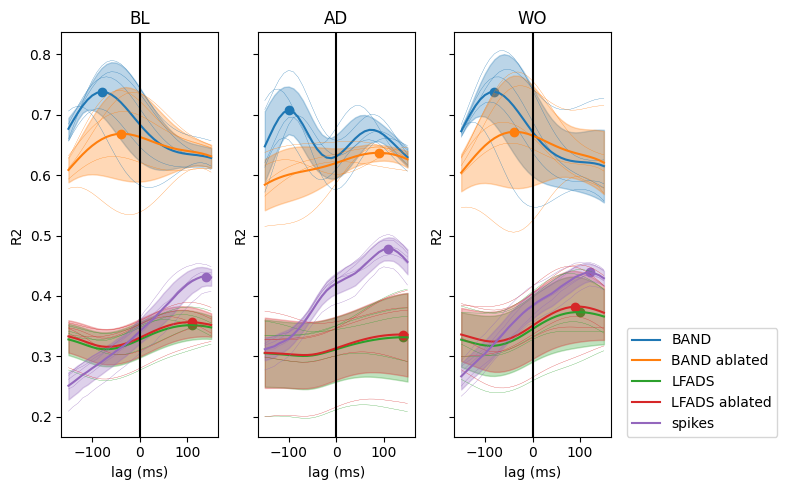

In [76]:
fig, axes = plt.subplots(1,3,figsize=(8,5),sharey=True)

for epoch,epoch_name in enumerate(['BL','AD','WO']):
    
    all_lagr2s = lagr2s_in_epochs[epoch]

    for i,key in enumerate(all_lagr2s.keys()):
        all_lagr2s[key] = np.array(all_lagr2s[key])
        mean = all_lagr2s[key][:,1].mean(0)
        std = all_lagr2s[key][:,1].std(0)
        axes[epoch].plot(all_lagr2s[key][0,0],mean, label = key, color=f'C{i}')
        axes[epoch].plot(all_lagr2s[key][:,0].T,all_lagr2s[key][:,1].T, color=f'C{i}',linewidth=.2)
        axes[epoch].fill_between(all_lagr2s[key][0,0], mean-std, mean+std, alpha=0.3, color=f'C{i}')
        argmax = np.argmax(mean)
        axes[epoch].scatter(all_lagr2s[key][0,0][argmax], mean[argmax], color=f'C{i}')
        print(key, all_lagr2s[key][0,0][argmax], mean[argmax])

    axes[epoch].axvline(0,c='k')
    axes[epoch].set_xlabel('lag (ms)')
    axes[epoch].set_ylabel('R2')
    axes[epoch].set_title(epoch_name)
    
plt.legend(loc=(1.1,0))
plt.tight_layout()


## how does fixed-lag velocity prediction change when ablating control?

Text(0.5, 1.1, '1-lag velocity X prediction from neural activity')

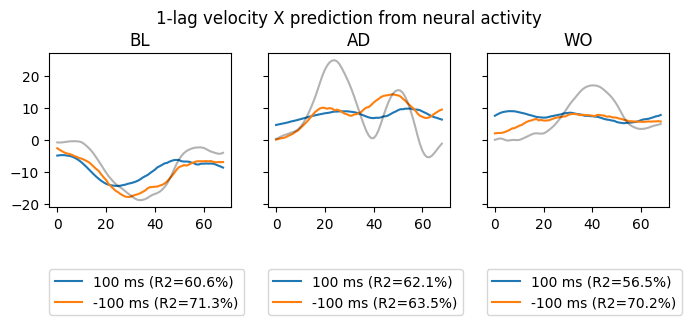

In [149]:
def predict_vel(x_train, x_test, true_train_beh, true_valid_beh, max_lag = 25,alpha=1):
    lags = [-10,10]
    Y_preds = []
    r2s = []
    for lag in lags:
        # ridge regression between lagged factors and behavior
        if lag==max_lag:
            X_train = x_train[:,max_lag+lag:].reshape(-1,x_train.shape[-1])
            X_test = x_test[:,max_lag+lag:].reshape(-1,x_test.shape[-1])
        else:
            X_train = x_train[:,max_lag+lag:-max_lag+lag].reshape(-1,x_train.shape[-1])
            X_test = x_test[:,max_lag+lag:-max_lag+lag].reshape(-1,x_test.shape[-1])

        Y_train = true_train_beh[:,max_lag:-max_lag].reshape(-1,true_train_beh.shape[-1])
        Y_test = true_valid_beh[:,max_lag:-max_lag]

        ridge = Ridge(alpha=alpha).fit(X_train, Y_train)
        Y_pred = ridge.predict(X_test).reshape(Y_test.shape)
        r2_score = 1 - np.sum((Y_pred - Y_test)**2) / (np.sum((Y_test - Y_test.mean(axis=0))**2)+1e-6)
        r2s.append(r2_score)
        Y_preds.append(Y_pred)
    return -np.array(lags)*10, np.array(Y_preds), r2s

fig, axes = plt.subplots(1,3,figsize=(8,2),sharey=True)
alpha=alpha_band
seed = 0
start, end = 0, 99
max_lag = 15

predictions = []

for epoch, epoch_name in enumerate(['BL','AD','WO']):

    predictions_fold = []   
    for fold in range(N_FOLDS):
        lfads = 2*fold + 0
        band = 2*fold + 1
        
        train_factors, valid_factors = both_train_factors[band][both_train_epochs[band] == epoch], both_factors[band][both_valid_epochs[band] == epoch]
        train_beh, valid_beh = true_train_behs[band][both_train_epochs[band] == epoch], true_valid_behs[band][both_valid_epochs[band] == epoch]
        
        lags, Y_preds, r2 = predict_vel(train_factors[:,start:end],
                            valid_factors[:,start:end], 
                            train_beh[:,start:end],
                            valid_beh[:,start:end],
                            alpha=alpha, max_lag=max_lag)
        
        predictions_fold.append(np.concatenate([Y_preds,valid_beh[:,start+max_lag:end-max_lag][np.newaxis,...]],0)) 
        # [epochs, lags + true, trials, time (minus 2 max lags), dim]
    
    predictions.append(predictions_fold)

    trial = 0
    for i in range(len(lags)):
        axes[epoch].plot(Y_preds[i][trial,:,0], label = f'{lags[i]} ms (R2={100*r2[i]:.1f}%)', color=f'C{i}')
    axes[epoch].plot(valid_beh[trial,start+max_lag:end-max_lag,0].T, color='k', alpha=0.3)
    axes[epoch].legend(loc=(0.,-.7))
    axes[epoch].set_title(epoch_name)

plt.suptitle('1-lag velocity X prediction from neural activity',y=1.1)


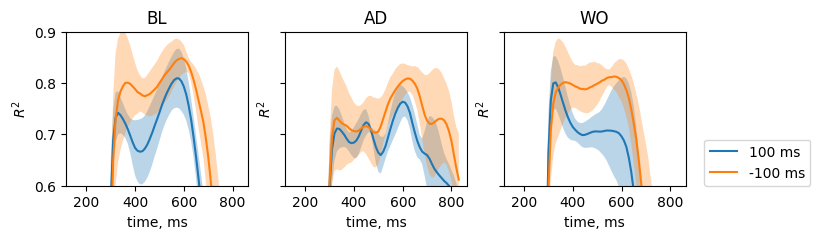

In [150]:
fig, axes = plt.subplots(1,3,figsize=(8,2),sharey=True)

for epoch, epoch_name in enumerate(['BL','AD','WO']):

    pr = predictions[epoch] # [folds, lags + true, trials, time (minus 2 max lags), dim]

    mse = []
    for fold in range(N_FOLDS):
        preds = np.array(pr[fold])[:len(lags)]
        true_beh = np.array(pr[fold])[-1:]
        mse_fold = np.sum((preds - true_beh)**2, axis=(-1)).mean(1) # mean over trials
        mse.append(mse_fold)

    var = np.sum((true_beh - true_beh.mean(axis=1))**2,axis=-1).mean(1)[0]
    v_mean = np.mean(1-mse/var,axis=0) # mean over folds
    v_std = np.std(1-mse/var,axis=0) # std over folds
    time = np.arange(start+max_lag,end-max_lag)*10

    
    axes[epoch].plot(time, v_mean.T, label = [f'{lags[i]} ms' for i in range(len(lags))])
    axes[epoch].set_ylim([0.6,.9])
    for i in range(len(lags)):
        axes[epoch].fill_between(time, (v_mean[i]-v_std[i]).T, (v_mean[i]+v_std[i]).T, alpha=0.3)
    axes[epoch].set_title(epoch_name)
    axes[epoch].set_xlabel('time, ms')
    axes[epoch].set_ylabel(r'$R^2$')

    if epoch == 2:
        axes[epoch].legend(loc=(1.1,0))
    

# Make a print-ready figure

In [152]:
from goodman_panels import panels, panel_specs, label_panel, label_panels
import matplotlib as mpl

In [153]:
def make_task_schematics(ax, x,y,r,aspect=1.,shown=np.ones(8)):

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # draw a circle around the center with 8 target directions
    theta = np.roll(np.linspace(0,2*np.pi,9)[:-1],3)
    x_t = x + r*np.cos(theta)
    y_t = y + r*np.sin(theta)*aspect

    for c, (s, xt, yt) in enumerate(zip(shown, x_t,y_t)):
        fill = {'facecolors': f'C{c}'} if s else {'facecolors': 'none'}
        ax.scatter(xlim[0] + (xlim[1] - xlim[0])*xt,
                    ylim[0] + (ylim[1] - ylim[0])*yt,
                    s=20,edgecolors=f'C{c}',linewidth=.5,
                    **fill)
    ax.scatter(xlim[0] + (xlim[1] - xlim[0]) * x,
                ylim[0] + (ylim[1] - ylim[0]) * y,
                s = 20, c='k', marker='+',linewidth=.5)

In [171]:
main_lag = -9
select = [6]
skip = 5 # skip every other trial for plotting factors

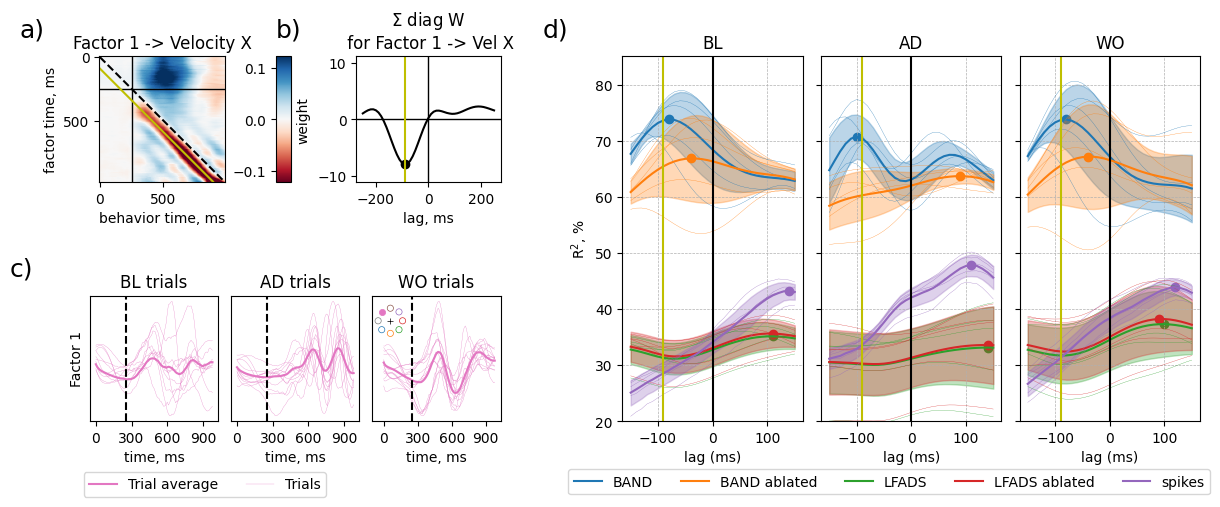

In [223]:
layout = '''
AaB.D
CCC.D
'''
fig = plt.figure(figsize=(12, 5))
# blank = fig.add_subplot([0,0,1,1])
specs, gs = panel_specs(layout, fig=fig, gridspec_args={'left': 0.065, 'right': .99, 'bottom': 0.17, 'top': 0.9, 'hspace': .9, 'wspace': .3})

gs.set_width_ratios([1,.1,1,0.1,4])
gs.set_height_ratios([1,1])

axes = {}
for letter in 'A':
    axes[letter] = ax = fig.add_subplot(specs[letter])
    label_panel(ax, letter.lower(),postfix=')')

axes['a'] = ax = fig.add_subplot(specs['a'])
# manually move left
p = ax.get_position()
ax.set_position([p.x0-.01, p.y0, p.width, p.height])

for letter in 'B':
    axes[letter] = ax = fig.add_subplot(specs[letter])
    label_panel(ax, letter.lower(),postfix=')')

for letter in 'CD':
    subgs = specs[letter].subgridspec(1, 3, wspace=0.1)
    for i in range(3):
        axes[f"{letter}{i}"] = ax = fig.add_subplot(subgs[i])
    label_panel(axes[f'{letter}0'], letter.lower(), postfix=')')

# select what to plot
factor_id = 1
beh_id = 0
factors = concat_factors[1] # BAND
time = np.arange(factors.shape[1]) * 10

# Panel A: plot oscillation weights & factors
r = np.std(beh_W)*5
im = axes['A'].imshow(beh_W[:,factor_id,:,beh_id], cmap='RdBu', vmin=-r, vmax=r)
axes['A'].set_xlabel('behavior time, ms')
axes['A'].set_ylabel('factor time, ms')
axes['A'].plot([0,seq_len-1], [0, seq_len-1], 'k--')
axes['A'].set_title(f'Factor {factor_id} -> Velocity X')
axes['A'].axvline(25, color='k', linewidth=1)
axes['A'].axhline(25, color='k', linewidth=1)
axes['A'].set_xticks([0,50,100])
axes['A'].set_xticklabels([0,500,1000])
axes['A'].set_yticks([0,50,100])
axes['A'].set_yticklabels([0,500,1000])
axes['A'].plot([0,seq_len-1+main_lag], [0-main_lag, seq_len-1], 'y')
# add a colorbar
cbar = mpl.colorbar.ColorbarBase(axes['a'], cmap=im.cmap, norm=im.norm,
                                orientation='vertical', label='weight')
axes['a'].yaxis.tick_left()

co = 25
r = np.std(beh_W[:,j,:,:])*5
w = beh_W[:,factor_id,:,beh_id][co:,co:]
lags = np.arange(-25, 26)
amp = np.zeros_like(lags, dtype=float)
for k,lag in enumerate(lags):
    amp[k] = np.sum(np.diag(w, k=lag))
axes[f'B'].plot(10*lags,amp, color='k')
id_max = np.argmax(np.abs(amp))
axes[f'B'].scatter(10*lags[id_max], amp[id_max], color='k')
axes[f'B'].axhline(0, color='k', linewidth=1)
axes[f'B'].axvline(0, color='k', linewidth=1)
axes[f'B'].set_ylim([-r*75,r*75])
axes[f'B'].axvline(10*main_lag,c='y')
axes[f'B'].set_xlabel(f'lag, ms')
axes[f'B'].set_title(r'$\Sigma$'+ f' diag W \n for Factor {factor_id} -> Vel X')

unique_dirs = np.unique(true_target_direction)

for e, e_title in enumerate(["BL", "AD", "WO"]):
    for k, d in enumerate(unique_dirs):
        if d in unique_dirs[select]:
            mask = (concat_target_direction == d) & (concat_epochs == e)
            label = 'Trial average' if d == unique_dirs[select[0]] else None
            axes[f'C{e}'].plot(
                time, factors[..., factor_id][mask].mean(0), linewidth=1.5, c=f"C{k}", label=label
            )
            label = ['Trials'] + [None for _ in range((np.sum(mask)-1)//2)] if d == unique_dirs[select[0]] else None
            axes[f'C{e}'].plot(
                time, factors[..., factor_id][mask][::2].T, linewidth=0.2, c=f"C{k}", alpha=1, label=label
            )
            axes[f'C{e}'].set_yticks([])
            axes[f'C{e}'].set_xlabel("time, ms")
            axes[f'C{e}'].set_title(f"{e_title} trials")
            axes[f'C{e}'].set_xticks([0, 300, 600, 900])
            axes[f'C{e}'].axvline(10*co, color='k', linestyle='--')
            if e == 0:
                axes[f'C{e}'].legend(loc=[-.05,-.6], ncol = 3 )
                axes[f'C{e}'].set_ylabel(f"Factor {factor_id}")
            else:
                axes[f'C{e}'].set_yticklabels([])

one_hot_select = [1 if s in select else 0 for s in range(8)]    
make_task_schematics(axes[f'C2'], 0.1, .8, 0.1,aspect=1.,shown=one_hot_select)

# Panel D: plot fixed-lag R2
for epoch,epoch_name in enumerate(['BL','AD','WO']):
    
    for panel_letter,all_lagr2s in zip(['D'],[lagr2s_in_epochs[epoch]]):

        for i,key in enumerate(['BAND','BAND ablated','LFADS','LFADS ablated','spikes']):
            all_lagr2s[key] = np.array(all_lagr2s[key])
            mean = 100*all_lagr2s[key][:,1].mean(0)
            std = 100*all_lagr2s[key][:,1].std(0)
            axes[f'{panel_letter}{epoch}'].plot(all_lagr2s[key][0,0],mean, label = key, color=f'C{i}')
            axes[f'{panel_letter}{epoch}'].plot(all_lagr2s[key][:,0].T,100*all_lagr2s[key][:,1].T, color=f'C{i}',linewidth=.2)
            axes[f'{panel_letter}{epoch}'].fill_between(all_lagr2s[key][0,0], mean-std, mean+std, alpha=0.3, color=f'C{i}')
            argmax = np.argmax(mean)
            axes[f'{panel_letter}{epoch}'].scatter(all_lagr2s[key][0,0][argmax], mean[argmax], color=f'C{i}')

        axes[f'{panel_letter}{epoch}'].axvline(0,c='k')
        axes[f'{panel_letter}{epoch}'].set_xlabel('lag (ms)')
        axes[f'{panel_letter}{epoch}'].set_title(epoch_name)
        axes[f'{panel_letter}{epoch}'].axvline(10*main_lag,c='y')
        axes[f'{panel_letter}{epoch}'].set_ylim([20,85])
        # add grid
        axes[f'{panel_letter}{epoch}'].grid(True, which='both', linestyle='--', linewidth=.5)

        if epoch==0:
            axes[f'{panel_letter}{epoch}'].set_ylabel(r'R$^2$, %')
        else:
            axes[f'{panel_letter}{epoch}'].set_yticklabels([])
        
axes['D1'].legend(loc=(-1.4,-0.2),ncol=5)

plt.savefig(f'figs/Fig6.pdf')


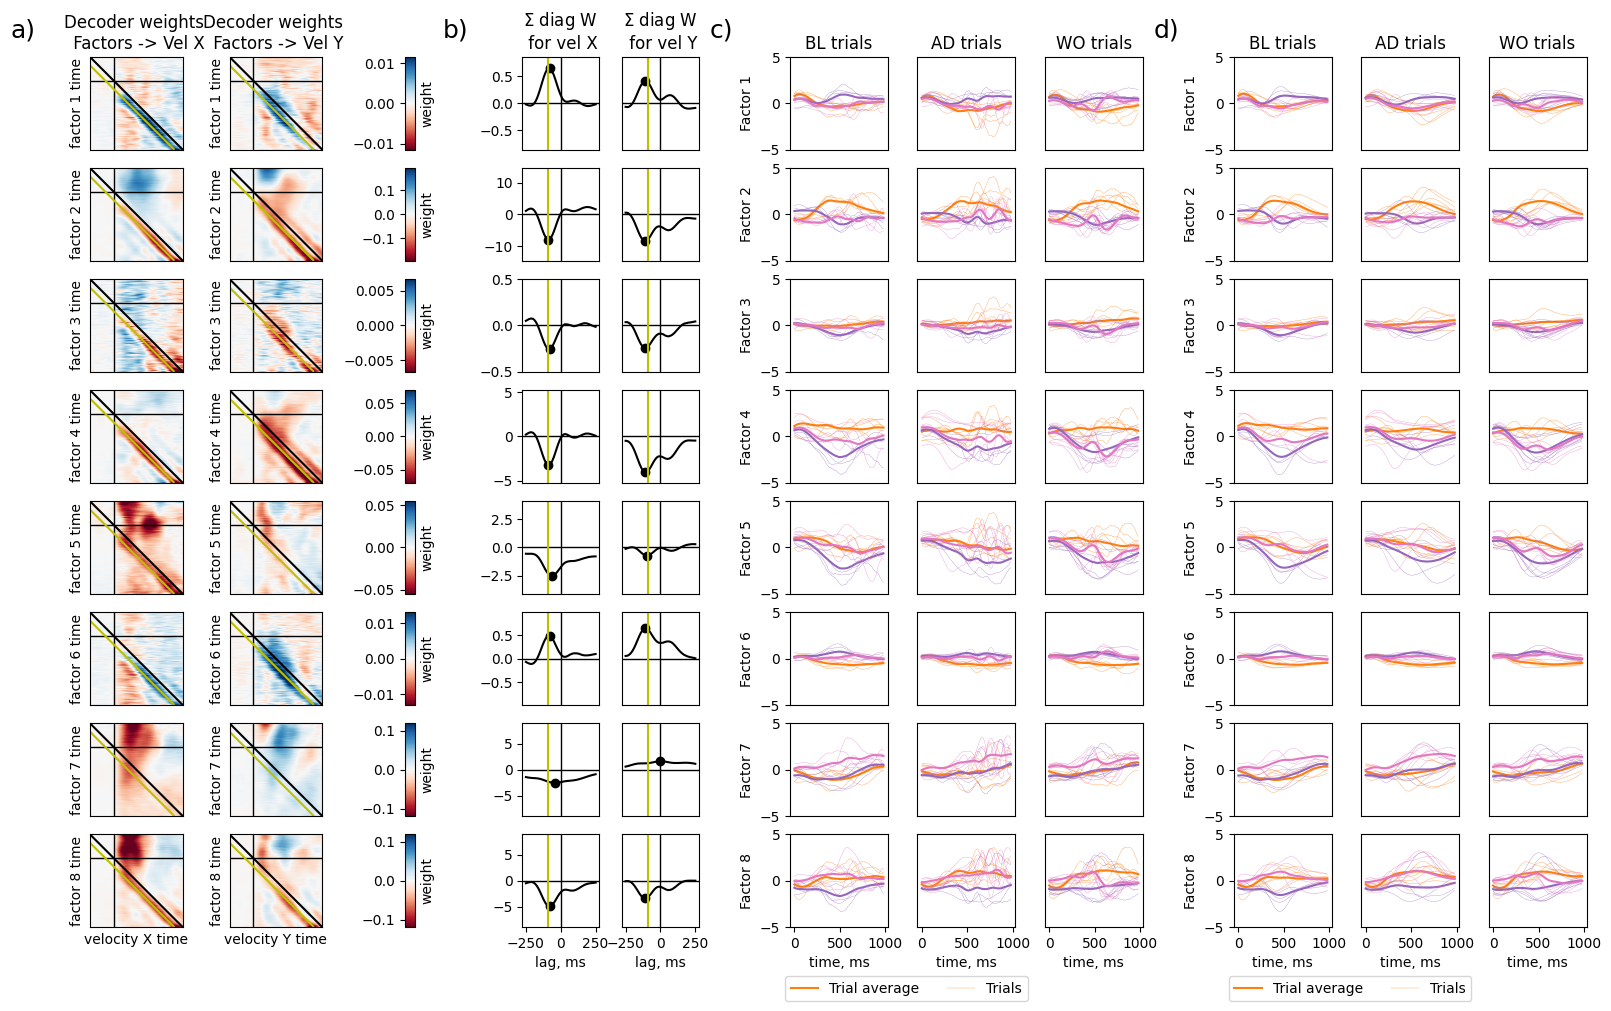

In [156]:
layout = '''
AaBCD
'''
fig = plt.figure(figsize=(16, 10))
# blank = fig.add_subplot([0,0,1,1])
specs, gs = panel_specs(layout, fig=fig, gridspec_args={'left': 0.05, 'right': .99, 'bottom': 0.08, 'top': 0.95, 'hspace': 1, 'wspace': .4})
axes = {}
gs.set_width_ratios([0.7,.03,.5,1,1])
# gs.set_height_ratios([1])

assert in_features < 10, 'Don\'t visualize the whole large model'
subgs = specs['A'].subgridspec(in_features, 2, wspace=0.3)
for i in range(in_features):
    for j in range(2):
        axes[f"A{i}{j}"] = ax = fig.add_subplot(subgs[i,j])
label_panel(axes['A00'], 'a', postfix=')')

subgs = specs['a'].subgridspec(in_features, 1, wspace=0.)
for i in range(in_features):
    axes[f"a{i}"] = ax = fig.add_subplot(subgs[i])
    # manually move left
    p = ax.get_position()
    ax.set_position([p.x0-.01, p.y0, p.width, p.height])

subgs = specs['B'].subgridspec(in_features, 2, wspace=0.3)
for i in range(in_features):
    for j in range(2):
        axes[f"B{i}{j}"] = ax = fig.add_subplot(subgs[i,j])
label_panel(axes['B00'], 'b', postfix=')')

subgs = specs['C'].subgridspec(in_features, 3, wspace=0.3)
for i in range(in_features):
    for j in range(3):
        axes[f"C{i}{j}"] = ax = fig.add_subplot(subgs[i,j])
label_panel(axes['C00'], 'c', postfix=')')

subgs = specs['D'].subgridspec(in_features, 3, wspace=0.3)
for i in range(in_features):
    for j in range(3):
        axes[f"D{i}{j}"] = ax = fig.add_subplot(subgs[i,j])
label_panel(axes['D00'], 'd', postfix=')')


beh_W = np.array([b.detach().numpy() for b in beh_Ws]).mean(0)

for j in range(in_features):
    r = np.std(beh_W[:,j,:,:])*4
    for i in range(out_features):
        im = axes[f'A{j}{i}'].imshow(beh_W[:,j,:,i], cmap='RdBu', vmin=-r, vmax=r)
        axes[f'A{j}{i}'].set_xticks([])
        axes[f'A{j}{i}'].set_yticks([])
        axes[f'A{j}{i}'].plot([0,seq_len-1], [0, seq_len-1], 'k')
        axes[f'A{j}{i}'].axvline(25, color='k', linewidth=1)
        axes[f'A{j}{i}'].axhline(25, color='k', linewidth=1)
        axes[f'A{j}{i}'].plot([0,seq_len-1+main_lag], [0-main_lag, seq_len-1], 'y')

        axes[f'A{j}{i}'].set_ylabel(f'factor {j+1} time')
        comp_name = 'X' if i==0 else 'Y'
        if j == in_features - 1:
            axes[f'A{j}{i}'].set_xlabel(f'velocity {comp_name} time')

    # add a colormap
    cb = mpl.colorbar.ColorbarBase(axes[f'a{j}'], cmap=im.cmap, norm=im.norm,
                                orientation='vertical', label='weight')
    axes[f'a{j}'].yaxis.tick_left()

for i,n in enumerate(['Vel X','Vel Y']):
    axes[f'A0{i}'].set_title(f'Decoder weights \n Factors -> {n}')

for j in range(in_features):
    r = np.std(beh_W[:,j,:,:])*4
    for i in range(out_features):
        for co, co_c in zip([25],['k']):
            w = beh_W[:,j,:,i][co:,co:]
            lags = np.arange(-25, 26)
            amp = np.zeros_like(lags, dtype=float)
            for k,lag in enumerate(lags):
                amp[k] = np.sum(np.diag(w, k=lag))
            axes[f'B{j}{i}'].plot(10*lags,amp, color=co_c)
            id_max = np.argmax(np.abs(amp))
            axes[f'B{j}{i}'].scatter(10*lags[id_max], amp[id_max], color=co_c)
        axes[f'B{j}{i}'].axhline(0, color='k', linewidth=1)
        axes[f'B{j}{i}'].axvline(0, color='k', linewidth=1)
        axes[f'B{j}{i}'].set_ylim([-r*75,r*75])
        axes[f'B{j}{i}'].axvline(10*main_lag,c='y')
        if j==in_features-1:
            axes[f'B{j}{i}'].set_xlabel(f'lag, ms')
        else:
            axes[f'B{j}{i}'].set_xticks([])
        if i == 1:
            axes[f'B{j}{i}'].set_yticks([])
        
    # axes[f'B{j}0'].set_ylabel(r'$\Sigma$diag weights')

for i,n in enumerate(['vel X','vel Y']):
    axes[f'B0{i}'].set_title(r'$\Sigma$'+ f' diag W \n for {n}')

# Panel C: factors
unique_dirs = np.unique(true_target_direction)
factors = concat_factors[1] # BAND
factors_noci = concat_factors_noci[1] # BAND ablated
time = np.arange(factors.shape[1]) * 10

for factor_id in range(in_features):
    for e, e_title in enumerate(["BL", "AD", "WO"]):
        for k, d in enumerate(unique_dirs):
            if d in unique_dirs[select]:
                mask = (concat_target_direction == d) & (concat_epochs == e)
                label = 'Trial average' if d == unique_dirs[select[0]] else None
                axes[f'C{factor_id}{e}'].plot(
                    time, factors[..., factor_id][mask].mean(0) - factors[..., factor_id].mean(), linewidth=1.5, c=f"C{k}", label=label,
                )
                label = ['Trials'] + [None for _ in range((np.sum(mask)-1)//skip)] if d == unique_dirs[select[0]] else None
                axes[f'C{factor_id}{e}'].plot(
                    time, factors[..., factor_id][mask][::skip].T - factors[..., factor_id].mean(), linewidth=0.2, c=f"C{k}", alpha=1, label=label
                )

                label = 'Trial average' if d == unique_dirs[select[0]] else None
                axes[f'D{factor_id}{e}'].plot(
                    time, factors_noci[..., factor_id][mask].mean(0) - factors[..., factor_id].mean(), linewidth=1.5, c=f"C{k}", label=label
                )
                label = ['Trials'] + [None for _ in range((np.sum(mask)-1)//skip)] if d == unique_dirs[select[0]] else None
                axes[f'D{factor_id}{e}'].plot(
                    time, factors_noci[..., factor_id][mask][::skip].T - factors[..., factor_id].mean(), linewidth=0.2, c=f"C{k}", alpha=1, label=label
                )


                axes[f'C{factor_id}{e}'].set_ylim([-5,5])
                axes[f'D{factor_id}{e}'].set_ylim([-5,5])

                for letter in ['C','D']:
                    if e==0:
                        axes[f'{letter}{factor_id}{e}'].set_ylabel(f"Factor {factor_id+1}")
                        # axes[f'{letter}{factor_id}{e}'].set_yticks([])
                    else:
                        axes[f'{letter}{factor_id}{e}'].set_yticks([])
                    if factor_id == in_features-1:
                        axes[f'{letter}{factor_id}{e}'].set_xticks([0, 500, 1000])
                        axes[f'{letter}{factor_id}{e}'].set_xlabel("time, ms")
                    else:
                        axes[f'{letter}{factor_id}{e}'].set_xticks([])
                    if factor_id == 0:
                        axes[f'{letter}{factor_id}{e}'].set_title(f"{e_title} trials")
                    if (e == 0) & (factor_id == in_features-1):
                        axes[f'{letter}{factor_id}{e}'].legend(loc=[-.05,-.8], ncol = 2 )

plt.savefig('figs/Supl_fig6.pdf')

: 